In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os
import pickle
import datetime
from tqdm import tqdm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

# Check GPU availability
print("Checking for GPU availability...")
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print(f"GPU found: {physical_devices}")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Memory growth enabled for GPU")
else:
    print("No GPU found, using CPU")

def load_data(file_path):
    """Load and preprocess the TSI data"""
    print(f"Loading data from {file_path}...")
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
    df = df.set_index('date')
    print(f"Data loaded. Shape: {df.shape}")
    return df

def create_forecast_sequences(data, seq_length, forecast_horizon):
    """Create sequences for training with specified length and forecast horizon"""
    X, y = [], []
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+forecast_horizon])
    return np.array(X), np.array(y)

def calculate_metrics(y_true, y_pred, y_lower, y_upper):
    """Calculate evaluation metrics: RMSE, PICP, MPIW"""
    # Ensure data consistency
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    y_lower = y_lower.flatten()
    y_upper = y_upper.flatten()

    # Check for NaN values
    if np.isnan(y_true).any() or np.isnan(y_pred).any():
        return np.nan, np.nan, np.nan

    # RMSE Calculation
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # PICP Calculation
    within_interval = np.logical_and(y_true >= y_lower, y_true <= y_upper)
    picp = np.mean(within_interval)

    # MPIW Calculation
    mpiw = np.mean(y_upper - y_lower)

    return rmse, picp, mpiw

def create_train_model(X_train, y_train, forecast_horizon):
    """Create and train MC Dropout model"""
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(forecast_horizon)
    ])

    model.compile(optimizer='adam', loss='mse')

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=0
    )

    history = model.fit(
        X_train, y_train,
        epochs=50,  # Reduced epochs for faster testing
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )

    return model, history

def generate_mc_dropout_forecasts(X_train, y_train, X_val, forecast_horizon, num_samples=30):
    """Generate Monte Carlo Dropout forecasts"""
    # Create and train model
    model, _ = create_train_model(X_train, y_train, forecast_horizon)

    # Create MC Dropout prediction function
    class MCDropoutModel(tf.keras.Model):
        def __init__(self, model):
            super(MCDropoutModel, self).__init__()
            self.model = model

        def call(self, inputs, training=True):
            return self.model(inputs, training=True)

    mc_model = MCDropoutModel(model)

    # Generate multiple predictions with dropout enabled
    forecasts = []

    for _ in range(num_samples):
        forecast = mc_model.predict(X_val, verbose=0)
        forecasts.append(forecast)

    forecasts = np.array(forecasts)

    mean_forecast = np.mean(forecasts, axis=0)
    lower_bound = np.quantile(forecasts, 0.05, axis=0)
    upper_bound = np.quantile(forecasts, 0.95, axis=0)

    return mean_forecast, lower_bound, upper_bound, model, forecasts

def predict_future_mc_dropout(model, last_sequence, future_steps, forecast_horizon, scaler, num_samples=30):
    """Predict future values using MC Dropout"""
    # Create MC Dropout prediction function
    class MCDropoutModel(tf.keras.Model):
        def __init__(self, model):
            super(MCDropoutModel, self).__init__()
            self.model = model

        def call(self, inputs, training=True):
            return self.model(inputs, training=True)

    mc_model = MCDropoutModel(model)

    future_predictions_samples = []

    for _ in range(num_samples):
        future_predictions = []
        curr_sequence = last_sequence.copy()

        steps_completed = 0
        while steps_completed < future_steps:
            curr_sequence_reshaped = curr_sequence.reshape(1, curr_sequence.shape[0], curr_sequence.shape[1])

            # Predict next forecast_horizon steps with dropout enabled
            next_preds = mc_model.predict(curr_sequence_reshaped, verbose=0)[0]

            # Add as many predictions as needed
            steps_to_add = min(forecast_horizon, future_steps - steps_completed)
            future_predictions.extend(next_preds[:steps_to_add])

            # Update the sequence for the next iteration
            curr_sequence = np.roll(curr_sequence, -steps_to_add, axis=0)
            curr_sequence[-steps_to_add:] = next_preds[:steps_to_add].reshape(-1, 1)

            steps_completed += steps_to_add

        future_predictions = np.array(future_predictions).reshape(-1, 1)
        future_predictions_samples.append(future_predictions)

    future_predictions_samples = np.array(future_predictions_samples)

    # Calculate statistics
    future_mean = np.mean(future_predictions_samples, axis=0)
    future_lower = np.quantile(future_predictions_samples, 0.05, axis=0)
    future_upper = np.quantile(future_predictions_samples, 0.95, axis=0)

    # Transform back to original scale
    future_mean = scaler.inverse_transform(future_mean)
    future_lower = scaler.inverse_transform(future_lower)
    future_upper = scaler.inverse_transform(future_upper)

    return future_mean, future_lower, future_upper

def generate_future_dates(last_date, num_months):
    """Generate future dates for forecasting"""
    future_dates = pd.date_range(start=last_date, periods=num_months+1, freq='MS')[1:]
    return future_dates

def calculate_evaluation_metrics(actual_values, mean_forecast_inv, lower_bound_inv, upper_bound_inv):
    """Calculate evaluation metrics across validation set"""
    rmse_values = []
    picp_values = []
    mpiw_values = []

    for i in range(len(actual_values)):
        rmse, picp, mpiw = calculate_metrics(
            actual_values[i],
            mean_forecast_inv[i],
            lower_bound_inv[i],
            upper_bound_inv[i]
        )
        if not np.isnan(rmse):
            rmse_values.append(rmse)
            picp_values.append(picp)
            mpiw_values.append(mpiw)

    if len(rmse_values) == 0:
        return np.nan, np.nan, np.nan

    return np.mean(rmse_values), np.mean(picp_values), np.mean(mpiw_values)

def plot_forecast(df, val_dates, mean_forecast_inv, lower_bound_inv, upper_bound_inv,
                 future_dates, future_mean, future_lower, future_upper,
                 training_start, validation_start, cycle_boundaries, forecast_horizon,
                 seq_length_years, num_cycles, title_suffix=""):
    """Plot forecasts with historical data and predictions"""
    plt.figure(figsize=(15, 8))

    # Historical data
    historical_mask = df.index >= training_start
    plt.plot(df.index[historical_mask], df['tsi'][historical_mask], 'b-', label='Historical Data')

    # Validation predictions with uncertainty
    for i in range(len(mean_forecast_inv)):
        pred_dates = val_dates[i:i+forecast_horizon]
        if len(pred_dates) == len(mean_forecast_inv[i]):
            plt.plot(pred_dates, mean_forecast_inv[i], 'r-', alpha=0.5, label='Validation Predictions' if i == 0 else "")
            plt.fill_between(pred_dates, lower_bound_inv[i], upper_bound_inv[i], color='r', alpha=0.2, label='90% Confidence Interval' if i == 0 else "")

    # Future forecasts
    plt.plot(future_dates, future_mean, 'g-', label='Future Predictions')
    plt.fill_between(future_dates, future_lower.flatten(), future_upper.flatten(), color='g', alpha=0.2, label='Future 90% Confidence Interval')

    # Plot cycle boundaries
    for i, cycle_date in enumerate(cycle_boundaries):
        if cycle_date >= training_start:
            plt.axvline(x=cycle_date, color='k', linestyle='--', label=f'Cycle Boundary' if i == 0 else "")

    # Add vertical line for validation start
    plt.axvline(x=validation_start, color='purple', linestyle='-', label='Validation Start')

    # Title with parameters
    plt.title(f'TSI Forecast: {num_cycles} cycles, {seq_length_years} yr seq, {forecast_horizon} month horizon {title_suffix}')
    plt.xlabel('Date')
    plt.ylabel('TSI Number')
    plt.legend()
    plt.grid(True)

    # Create results directory if it doesn't exist
    results_dir = "parameter_test_results"
    os.makedirs(results_dir, exist_ok=True)

    # Save plot
    filename = f"{results_dir}/forecast_cycles{num_cycles}_seq{seq_length_years}_horizon{forecast_horizon}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

def run_parameter_test(df):
    """Run nested loops to test different parameters"""
    print("Starting parameter testing...")

    # Define cycle boundaries
    cycle_boundaries = [
        pd.to_datetime('1954-04-01'),  # Cycle 19
        pd.to_datetime('1964-10-01'),  # Cycle 20
        pd.to_datetime('1976-03-01'),  # Cycle 21
        pd.to_datetime('1986-09-01'),  # Cycle 22
        pd.to_datetime('1996-08-01'),  # Cycle 23
        pd.to_datetime('2008-12-01'),  # Cycle 24
        pd.to_datetime('2019-12-01'),  # Cycle 25
    ]

    # Fixed validation period
    validation_start = pd.to_datetime('2021-01-01')

    # Create scaler for the entire dataset
    tsi = df['tsi'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    tsi_scaled = scaler.fit_transform(tsi)

    # Set up parameter ranges
    cycle_counts = [2, 3, 4, 5, 6, 7]  # Number of solar cycles to use for training
    sequence_lengths_years = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]  # In years
    forecast_horizons = [1, 3, 6, 9, 12]  # In months

    # Set up results tracking
    results = []
    results_file = "parameter_test_results/results_summary.csv"
    os.makedirs(os.path.dirname(results_file), exist_ok=True)

    # Create a results DataFrame
    columns = ['Cycles', 'Training Start', 'Sequence Length (Years)',
               'Sequence Length (Months)', 'Forecast Horizon',
               'RMSE', 'PICP', 'MPIW', 'Status']
    results_df = pd.DataFrame(columns=columns)

    # Get validation dates
    val_dates = df.index[df.index >= validation_start]

    # Run the parameter grid search
    total_combinations = len(cycle_counts) * len(sequence_lengths_years) * len(forecast_horizons)
    print(f"Testing {total_combinations} parameter combinations...")

    combination_count = 0

    for cycle_count in cycle_counts:
        # Calculate how many cycles back from cycle 25 to use
        cycle_index = len(cycle_boundaries) - cycle_count
        if cycle_index < 0:
            cycle_index = 0

        # Set training start date based on cycle count
        training_start = cycle_boundaries[cycle_index]

        print(f"\nTesting with {cycle_count} solar cycles (starting from {training_start.strftime('%Y-%m')})")

        # Get indices for training data
        train_start_idx = df.index.searchsorted(training_start)
        val_start_idx = df.index.searchsorted(validation_start)

        if train_start_idx >= len(df):
            train_start_idx = len(df) - 1

        # Get scaled data for the selected period
        train_data = tsi_scaled[train_start_idx:val_start_idx]

        for seq_length_years in sequence_lengths_years:
            seq_length = seq_length_years * 12  # Convert years to months

            # Skip if sequence length is longer than available training data
            if seq_length >= len(train_data):
                print(f"  Skipping sequence length {seq_length_years} years - not enough training data")
                for forecast_horizon in forecast_horizons:
                    # Log skipped combination
                    new_row = {
                        'Cycles': cycle_count,
                        'Training Start': training_start,
                        'Sequence Length (Years)': seq_length_years,
                        'Sequence Length (Months)': seq_length,
                        'Forecast Horizon': forecast_horizon,
                        'RMSE': np.nan,
                        'PICP': np.nan,
                        'MPIW': np.nan,
                        'Status': 'Skipped - insufficient data'
                    }
                    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)
                    combination_count += 1
                continue

            print(f"  Testing sequence length: {seq_length_years} years ({seq_length} months)")

            for forecast_horizon in forecast_horizons:
                combination_count += 1
                print(f"    Combination {combination_count}/{total_combinations}: Testing forecast horizon: {forecast_horizon} months")

                try:
                    # Create sequences for training
                    X_train, y_train = create_forecast_sequences(train_data, seq_length, forecast_horizon)

                    # Check if we have enough training data
                    if len(X_train) < 10:  # Arbitrary minimum number of sequences
                        print(f"      Not enough training sequences ({len(X_train)}), skipping")
                        new_row = {
                            'Cycles': cycle_count,
                            'Training Start': training_start,
                            'Sequence Length (Years)': seq_length_years,
                            'Sequence Length (Months)': seq_length,
                            'Forecast Horizon': forecast_horizon,
                            'RMSE': np.nan,
                            'PICP': np.nan,
                            'MPIW': np.nan,
                            'Status': 'Skipped - insufficient sequences'
                        }
                        results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)
                        continue

                    # Reshape for LSTM
                    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

                    # Create validation sequences
                    X_val = []
                    y_val = []

                    # Get the available validation points
                    for i in range(len(val_dates) - forecast_horizon + 1):
                        # For each validation point, get sequence of preceding data points
                        current_val_date = val_dates[i]
                        # Find index of this date
                        val_idx = df.index.searchsorted(current_val_date)

                        # Make sure the index is valid
                        if val_idx >= len(df):
                            val_idx = len(df) - 1


                        # Get the previous seq_length data points
                        if val_idx - seq_length >= 0:
                            X_val.append(tsi_scaled[val_idx - seq_length:val_idx])
                            y_val.append(tsi_scaled[val_idx:val_idx + forecast_horizon])

                    # Make sure we have validation sequences
                    if len(X_val) == 0:
                        print("      No valid validation sequences, skipping")
                        new_row = {
                            'Cycles': cycle_count,
                            'Training Start': training_start,
                            'Sequence Length (Years)': seq_length_years,
                            'Sequence Length (Months)': seq_length,
                            'Forecast Horizon': forecast_horizon,
                            'RMSE': np.nan,
                            'PICP': np.nan,
                            'MPIW': np.nan,
                            'Status': 'Skipped - no validation sequences'
                        }
                        results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)
                        continue

                    X_val = np.array(X_val)
                    y_val = np.array(y_val)

                    # Reshape for LSTM
                    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

                    # Set the MC dropout samples
                    num_samples = 30  # Lower for faster testing

                    # Generate MC Dropout forecasts
                    print("      Training and generating forecasts...")
                    mean_forecast, lower_bound, upper_bound, model, forecasts = generate_mc_dropout_forecasts(
                        X_train, y_train, X_val, forecast_horizon, num_samples=num_samples
                    )

                    # Reshape forecasts for scaling back
                    mean_forecast_reshaped = mean_forecast.reshape(-1, forecast_horizon)
                    lower_bound_reshaped = lower_bound.reshape(-1, forecast_horizon)
                    upper_bound_reshaped = upper_bound.reshape(-1, forecast_horizon)

                    # Transform back to original scale
                    mean_forecast_inv = np.array([scaler.inverse_transform(f.reshape(-1, 1)).flatten()
                                              for f in mean_forecast_reshaped])
                    lower_bound_inv = np.array([scaler.inverse_transform(f.reshape(-1, 1)).flatten()
                                            for f in lower_bound_reshaped])
                    upper_bound_inv = np.array([scaler.inverse_transform(f.reshape(-1, 1)).flatten()
                                            for f in upper_bound_reshaped])

                    # Compute actual values for validation
                    actual_values = []
                    for i in range(len(y_val)):
                        inv_y = scaler.inverse_transform(y_val[i].reshape(-1, 1)).flatten()
                        actual_values.append(inv_y)
                    actual_values = np.array(actual_values)

                    # Calculate metrics
                    print("      Calculating metrics...")
                    avg_rmse, avg_picp, avg_mpiw = calculate_evaluation_metrics(
                        actual_values, mean_forecast_inv, lower_bound_inv, upper_bound_inv
                    )

                    # Generate future forecasts
                    print("      Generating future forecasts...")
                    last_sequence = tsi_scaled[-seq_length:].reshape(seq_length, 1)
                    last_date = df.index[-1]
                    future_steps = (2030 - last_date.year) * 12 + (12 - last_date.month)
                    future_dates = generate_future_dates(last_date, future_steps)

                    future_mean, future_lower, future_upper = predict_future_mc_dropout(
                        model, last_sequence, future_steps, forecast_horizon, scaler, num_samples=num_samples
                    )

                    # Plot results
                    print("      Creating visualization...")
                    plot_forecast(
                        df, val_dates, mean_forecast_inv, lower_bound_inv, upper_bound_inv,
                        future_dates, future_mean, future_lower, future_upper,
                        training_start, validation_start, cycle_boundaries, forecast_horizon,
                        seq_length_years, cycle_count,
                        title_suffix=f"(RMSE: {avg_rmse:.2f}, PICP: {avg_picp:.2f}, MPIW: {avg_mpiw:.2f})"
                    )

                    # Store results
                    new_row = {
                        'Cycles': cycle_count,
                        'Training Start': training_start,
                        'Sequence Length (Years)': seq_length_years,
                        'Sequence Length (Months)': seq_length,
                        'Forecast Horizon': forecast_horizon,
                        'RMSE': avg_rmse,
                        'PICP': avg_picp,
                        'MPIW': avg_mpiw,
                        'Status': 'Completed'
                    }
                    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

                    # Save incremental results
                    results_df.to_csv(results_file, index=False)

                except Exception as e:
                    print(f"      Error processing combination: {str(e)}")
                    new_row = {
                        'Cycles': cycle_count,
                        'Training Start': training_start,
                        'Sequence Length (Years)': seq_length_years,
                        'Sequence Length (Months)': seq_length,
                        'Forecast Horizon': forecast_horizon,
                        'RMSE': np.nan,
                        'PICP': np.nan,
                        'MPIW': np.nan,
                        'Status': f'Error: {str(e)}'
                    }
                    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)
                    results_df.to_csv(results_file, index=False)

    # Final save of all results
    results_df.to_csv(results_file, index=False)

    # Return the best parameters
    valid_results = results_df[results_df['Status'] == 'Completed']
    if len(valid_results) > 0:
        # Find best configuration based on RMSE
        best_rmse_idx = valid_results['RMSE'].idxmin()
        best_rmse_config = valid_results.loc[best_rmse_idx]

        print("\n===== BEST CONFIGURATION (RMSE) =====")
        print(f"Cycles: {best_rmse_config['Cycles']}")
        print(f"Sequence Length (Years): {best_rmse_config['Sequence Length (Years)']}")
        print(f"Forecast Horizon: {best_rmse_config['Forecast Horizon']}")
        print(f"RMSE: {best_rmse_config['RMSE']:.4f}")
        print(f"PICP: {best_rmse_config['PICP']:.4f}")
        print(f"MPIW: {best_rmse_config['MPIW']:.4f}")

        # Generate summary plots of parameter effects
        generate_summary_plots(results_df)

        return best_rmse_config
    else:
        print("No valid results found.")
        return None

def generate_summary_plots(results_df):
    """Generate summary plots showing parameter effects on metrics"""
    valid_results = results_df[results_df['Status'] == 'Completed'].copy()

    if len(valid_results) == 0:
        print("No valid results for summary plots")
        return

    results_dir = "parameter_test_results"
    os.makedirs(results_dir, exist_ok=True)

    # 1. Effect of cycle count on RMSE
    plt.figure(figsize=(12, 8))
    cycle_groups = valid_results.groupby('Cycles')['RMSE'].mean().reset_index()
    plt.bar(cycle_groups['Cycles'], cycle_groups['RMSE'])
    plt.xlabel('Number of Solar Cycles')
    plt.ylabel('Average RMSE')
    plt.title('Effect of Solar Cycle Count on RMSE')
    plt.xticks(cycle_groups['Cycles'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(f"{results_dir}/cycles_vs_rmse.png", dpi=300, bbox_inches='tight')
    plt.close()

    # 2. Effect of sequence length on RMSE
    plt.figure(figsize=(12, 8))
    seq_groups = valid_results.groupby('Sequence Length (Years)')['RMSE'].mean().reset_index()
    plt.bar(seq_groups['Sequence Length (Years)'], seq_groups['RMSE'])
    plt.xlabel('Sequence Length (Years)')
    plt.ylabel('Average RMSE')
    plt.title('Effect of Sequence Length on RMSE')
    plt.xticks(seq_groups['Sequence Length (Years)'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(f"{results_dir}/sequence_vs_rmse.png", dpi=300, bbox_inches='tight')
    plt.close()

    # 3. Effect of forecast horizon on RMSE
    plt.figure(figsize=(12, 8))
    horizon_groups = valid_results.groupby('Forecast Horizon')['RMSE'].mean().reset_index()
    plt.bar(horizon_groups['Forecast Horizon'], horizon_groups['RMSE'])
    plt.xlabel('Forecast Horizon (Months)')
    plt.ylabel('Average RMSE')
    plt.title('Effect of Forecast Horizon on RMSE')
    plt.xticks(horizon_groups['Forecast Horizon'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(f"{results_dir}/horizon_vs_rmse.png", dpi=300, bbox_inches='tight')
    plt.close()

    # 4. Heatmap of RMSE by sequence length and forecast horizon
    plt.figure(figsize=(14, 10))
    pivot_table = valid_results.pivot_table(
        values='RMSE',
        index='Sequence Length (Years)',
        columns='Forecast Horizon',
        aggfunc='mean'
    )
    sns.heatmap(pivot_table, annot=True, cmap='YlGnBu_r', fmt='.2f')
    plt.title('RMSE by Sequence Length and Forecast Horizon')
    plt.xlabel('Forecast Horizon (Months)')
    plt.ylabel('Sequence Length (Years)')
    plt.tight_layout()
    plt.savefig(f"{results_dir}/seq_horizon_heatmap.png", dpi=300, bbox_inches='tight')
    plt.close()

    # 5. Scatter plot of PICP vs MPIW
    plt.figure(figsize=(12, 8))
    plt.scatter(valid_results['MPIW'], valid_results['PICP'], c=valid_results['RMSE'], cmap='viridis')
    plt.colorbar(label='RMSE')
    plt.xlabel('Mean Prediction Interval Width (MPIW)')
    plt.ylabel('Prediction Interval Coverage Probability (PICP)')
    plt.title('Uncertainty Trade-off: PICP vs MPIW')
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{results_dir}/picp_vs_mpiw.png", dpi=300, bbox_inches='tight')
    plt.close()

    # 6. 3D plot of RMSE by cycles, sequence length and forecast horizon
    fig = plt.figure(figsize=(15, 12))
    ax = fig.add_subplot(111, projection='3d')

    x = valid_results['Cycles']
    y = valid_results['Sequence Length (Years)']
    z = valid_results['Forecast Horizon']
    c = valid_results['RMSE']

    sc = ax.scatter(x, y, z, c=c, cmap='viridis', s=60, alpha=0.8)
    ax.set_xlabel('Cycles')
    ax.set_ylabel('Sequence Length (Years)')
    ax.set_zlabel('Forecast Horizon (Months)')
    plt.colorbar(sc, label='RMSE')
    plt.title('3D View of Parameter Effects on RMSE')
    plt.savefig(f"{results_dir}/3d_parameter_effects.png", dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Summary plots saved to {results_dir}/")

def main():
    print("Starting TSI forecasting parameter testing...")

    # Load data
    # Update this path to your TSI data file
    file_path = '/Users/suryatejachalla/Projects/Solar-Data-Analysis/Data/processed/tsi.csv'
    df = load_data(file_path)
    print("Data summary:")
    print(df.describe())

    # Import seaborn for additional plots
    try:
        import seaborn as sns
        print("Seaborn imported successfully")
    except ImportError:
        print("Seaborn not available, some plots may be limited")

    # Make sure the 3D plotting will work
    try:
        from mpl_toolkits.mplot3d import Axes3D
        print("3D plotting available")
    except ImportError:
        print("3D plotting may not be available")

    # Run parameter testing
    best_config = run_parameter_test(df)

    # Re-run best configuration with more samples and detailed output
    if best_config is not None:
        print("\nRe-running best configuration with detailed output...")

        # Extract best parameters
        best_cycles = best_config['Cycles']
        best_seq_years = best_config['Sequence Length (Years)']
        best_horizon = best_config['Forecast Horizon']

        # Re-run with best parameters
        # This would be a complete separate run with the best parameters
        print(f"Best configuration: {best_cycles} cycles, {best_seq_years} yr sequence, {best_horizon} month horizon")
        print("Detailed run would be implemented here in a production version")

    print("\nParameter testing completed!")

if __name__ == "__main__":
    main()

Checking for GPU availability...
GPU found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Memory growth enabled for GPU
Starting TSI forecasting parameter testing...
Loading data from /Users/suryatejachalla/Projects/Solar-Data-Analysis/Data/processed/tsi.csv...
Data loaded. Shape: (925, 3)
Data summary:
              year       month          tsi
count   925.000000  925.000000   925.000000
mean   1985.624865    6.501622  1363.424393
std      22.267433    3.452405     0.354602
min    1947.000000    1.000000  1362.889401
25%    1966.000000    4.000000  1363.075357
50%    1986.000000    7.000000  1363.427821
75%    2005.000000    9.000000  1363.741952
max    2024.000000   12.000000  1364.138153
Seaborn imported successfully
3D plotting available
Starting parameter testing...
Testing 330 parameter combinations...

Testing with 2 solar cycles (starting from 2008-12)
  Testing sequence length: 1 years (12 months)
    Combination 1/330: Testing forecast horizon: 1 months


2025-03-17 20:16:45.066568: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-03-17 20:16:45.066593: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-03-17 20:16:45.066598: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-03-17 20:16:45.066612: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-17 20:16:45.066622: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-03-17 20:16:45.506606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


      Calculating metrics...
      Generating future forecasts...
      Creating visualization...
    Combination 2/330: Testing forecast horizon: 3 months
      Training and generating forecasts...
      Calculating metrics...
      Generating future forecasts...
      Creating visualization...
    Combination 3/330: Testing forecast horizon: 6 months
      Training and generating forecasts...
      Calculating metrics...
      Generating future forecasts...
      Creating visualization...
    Combination 4/330: Testing forecast horizon: 9 months
      Training and generating forecasts...
      Calculating metrics...
      Generating future forecasts...
      Creating visualization...
    Combination 5/330: Testing forecast horizon: 12 months
      Training and generating forecasts...
      Calculating metrics...
      Generating future forecasts...
      Creating visualization...
  Testing sequence length: 2 years (24 months)
    Combination 6/330: Testing forecast horizon: 1 months


AttributeError: 'float' object has no attribute 'view'

Error in callback <function _draw_all_if_interactive at 0x32eb244a0> (for post_execute), with arguments args (),kwargs {}:


AttributeError: 'float' object has no attribute 'view'

AttributeError: 'float' object has no attribute 'view'

<Figure size 1500x1200 with 2 Axes>

Total parameter combinations tested: 330
Completed combinations: 327
Skipped combinations: 3
Error combinations: 0

===== BEST CONFIGURATION (RMSE) =====
Cycles: 7
Sequence Length (Years): 1
Forecast Horizon: 1
RMSE: 0.0315
PICP: 0.9545
MPIW: 0.2015

Generating summary plots...


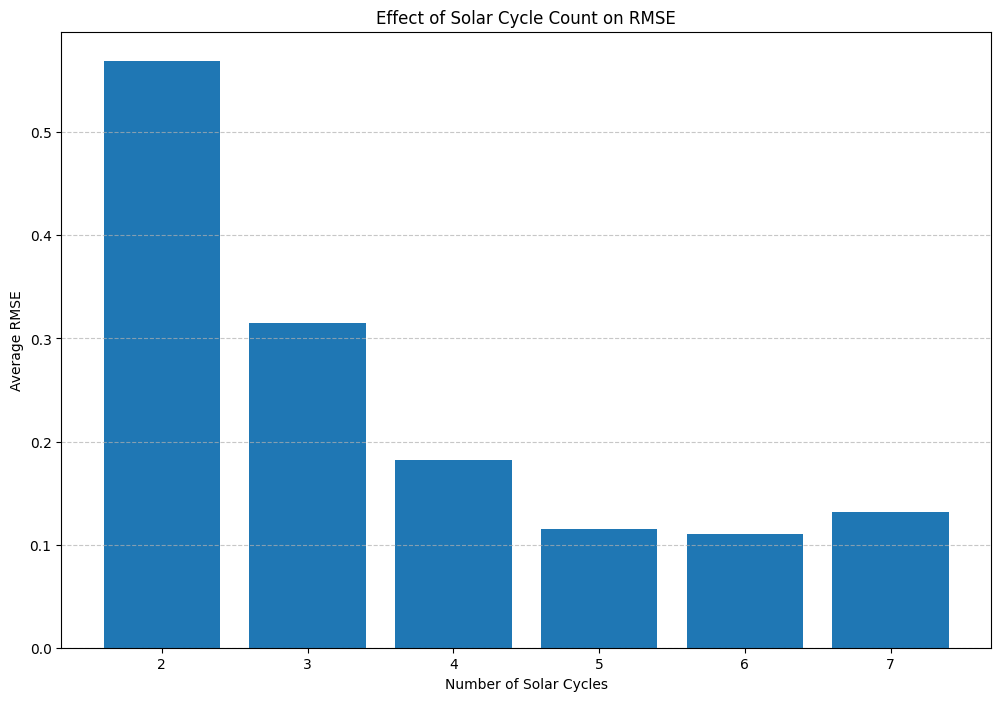

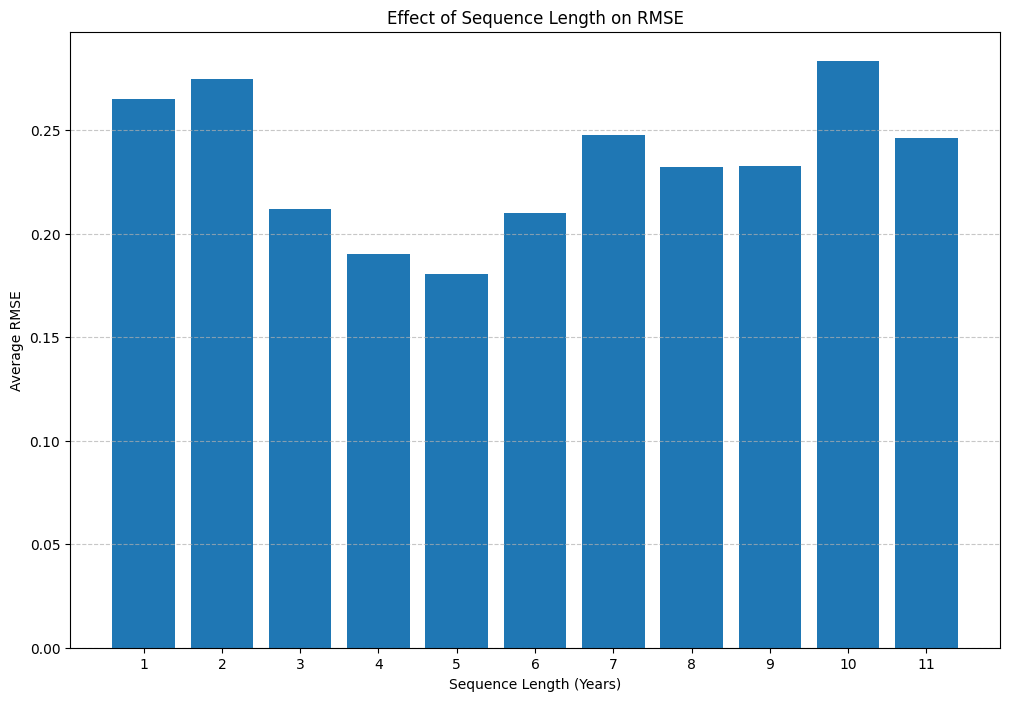

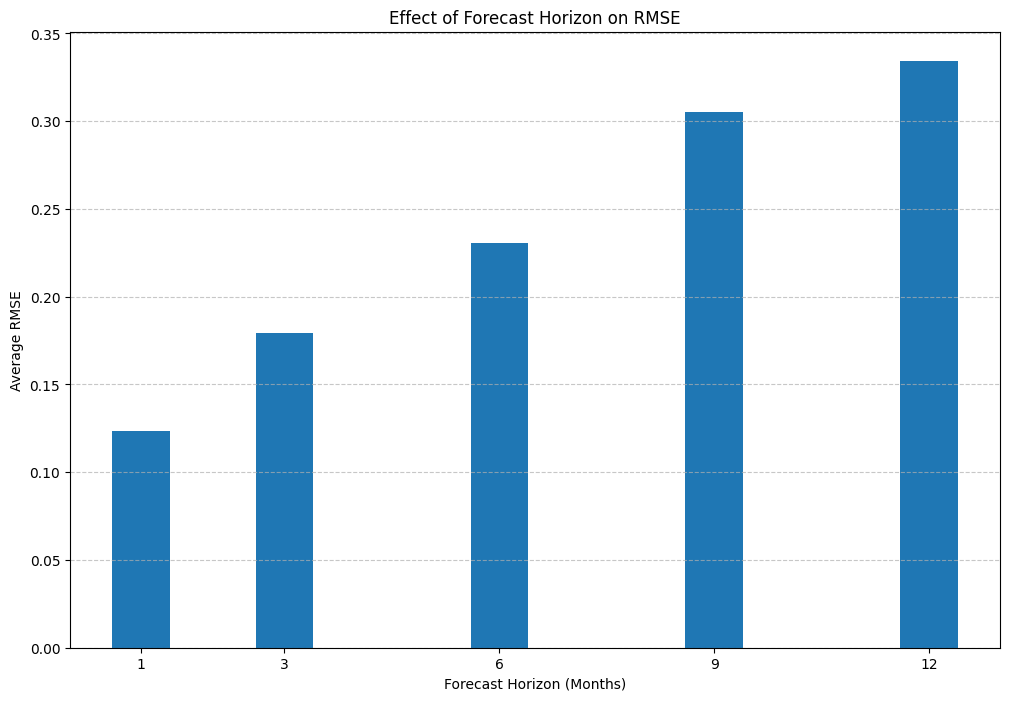

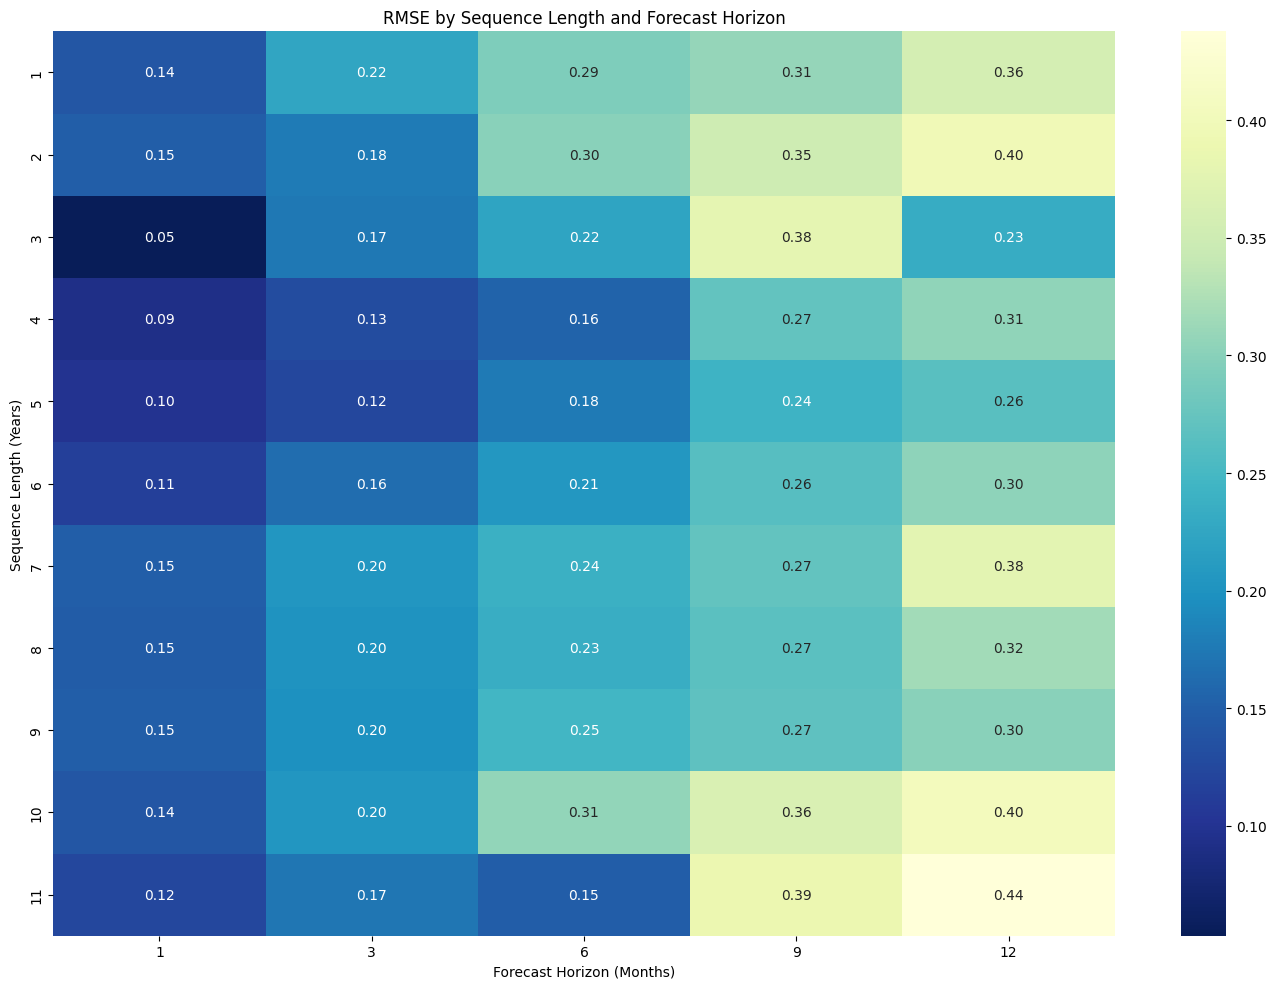

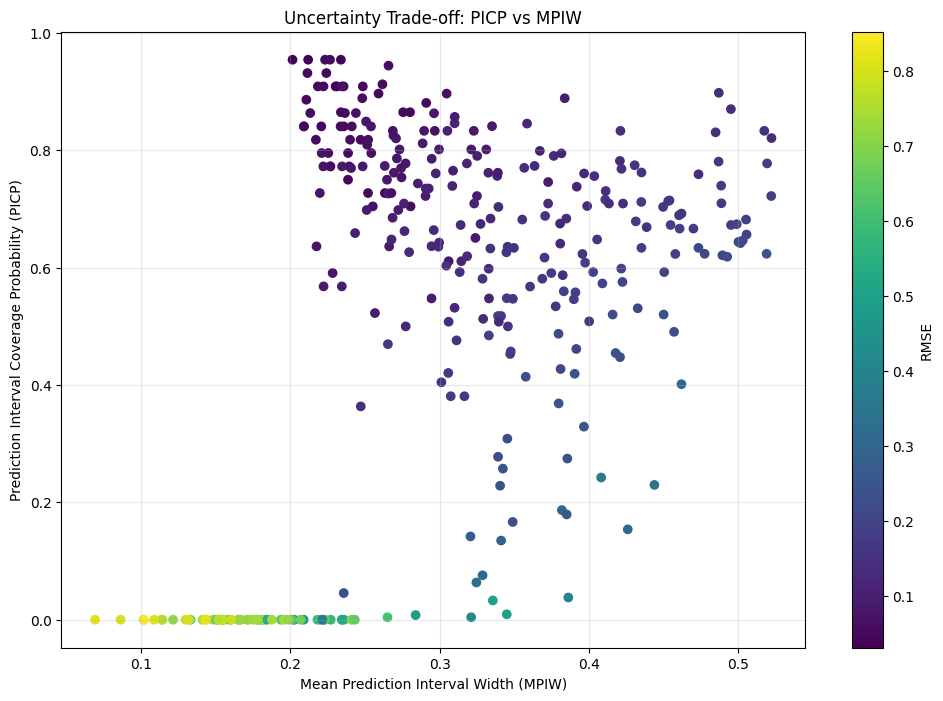

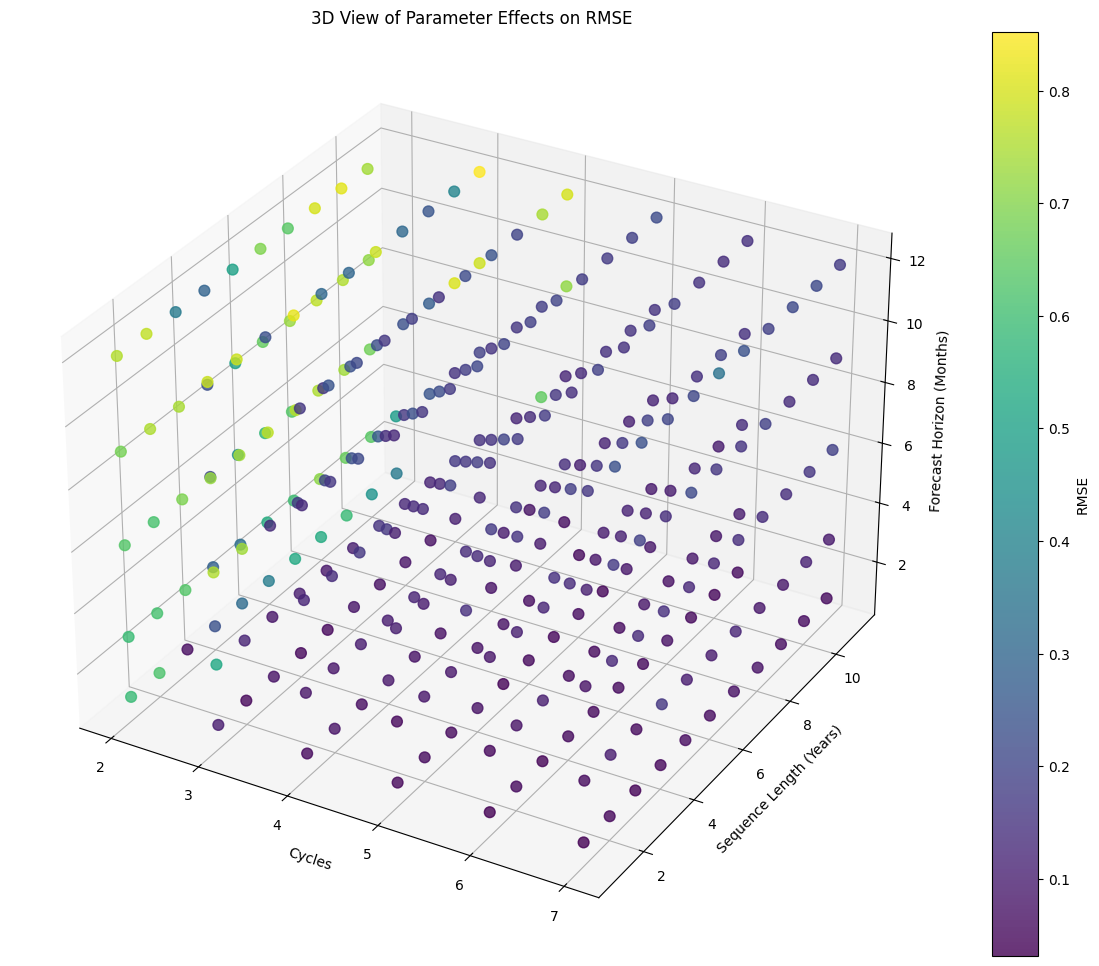


===== TOP 5 CONFIGURATIONS (LOWEST RMSE) =====
     Cycles  Sequence Length (Years)  Forecast Horizon      RMSE      PICP  \
275       7                        1                 1  0.031477  0.954545   
220       6                        1                 1  0.033701  0.909091   
285       7                        3                 1  0.035759  0.954545   
185       5                        5                 1  0.038610  0.909091   
230       6                        3                 1  0.039671  0.954545   

         MPIW  
275  0.201479  
220  0.230345  
285  0.211933  
185  0.231226  
230  0.233869  

===== PARAMETER IMPORTANCE =====

Mean RMSE by Cycle Count:
Cycles
6    0.110149
5    0.115058
7    0.131552
4    0.181953
3    0.314789
2    0.569065
Name: RMSE, dtype: float64

Mean RMSE by Sequence Length:
Sequence Length (Years)
5     0.180435
4     0.190429
6     0.209884
3     0.212209
8     0.232472
9     0.232716
11    0.246274
7     0.247947
1     0.265092
2     0.274811
10 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import os

# Path to your results file
results_file = "parameter_test_results/results_summary.csv"

# Create the directory if it doesn't exist
results_dir = "parameter_test_results"
os.makedirs(results_dir, exist_ok=True)

# Load the results
results_df = pd.read_csv(results_file)

# Print summary of the results
print(f"Total parameter combinations tested: {len(results_df)}")
print(f"Completed combinations: {len(results_df[results_df['Status'] == 'Completed'])}")
print(f"Skipped combinations: {len(results_df[results_df['Status'].str.contains('Skipped')])}")
print(f"Error combinations: {len(results_df[results_df['Status'].str.contains('Error')])}")

# Filter for valid results
valid_results = results_df[results_df['Status'] == 'Completed'].copy()

if len(valid_results) == 0:
    print("No valid results found.")
else:
    # Find best configuration based on RMSE
    best_rmse_idx = valid_results['RMSE'].idxmin()
    best_rmse_config = valid_results.loc[best_rmse_idx]

    print("\n===== BEST CONFIGURATION (RMSE) =====")
    print(f"Cycles: {best_rmse_config['Cycles']}")
    print(f"Sequence Length (Years): {best_rmse_config['Sequence Length (Years)']}")
    print(f"Forecast Horizon: {best_rmse_config['Forecast Horizon']}")
    print(f"RMSE: {best_rmse_config['RMSE']:.4f}")
    print(f"PICP: {best_rmse_config['PICP']:.4f}")
    print(f"MPIW: {best_rmse_config['MPIW']:.4f}")

    # Generate summary plots
    print("\nGenerating summary plots...")

    # 1. Effect of cycle count on RMSE
    plt.figure(figsize=(12, 8))
    cycle_groups = valid_results.groupby('Cycles')['RMSE'].mean().reset_index()
    plt.bar(cycle_groups['Cycles'], cycle_groups['RMSE'])
    plt.xlabel('Number of Solar Cycles')
    plt.ylabel('Average RMSE')
    plt.title('Effect of Solar Cycle Count on RMSE')
    plt.xticks(cycle_groups['Cycles'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(f"{results_dir}/cycles_vs_rmse.png", dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Effect of sequence length on RMSE
    plt.figure(figsize=(12, 8))
    seq_groups = valid_results.groupby('Sequence Length (Years)')['RMSE'].mean().reset_index()
    plt.bar(seq_groups['Sequence Length (Years)'], seq_groups['RMSE'])
    plt.xlabel('Sequence Length (Years)')
    plt.ylabel('Average RMSE')
    plt.title('Effect of Sequence Length on RMSE')
    plt.xticks(seq_groups['Sequence Length (Years)'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(f"{results_dir}/sequence_vs_rmse.png", dpi=300, bbox_inches='tight')
    plt.show()

    # 3. Effect of forecast horizon on RMSE
    plt.figure(figsize=(12, 8))
    horizon_groups = valid_results.groupby('Forecast Horizon')['RMSE'].mean().reset_index()
    plt.bar(horizon_groups['Forecast Horizon'], horizon_groups['RMSE'])
    plt.xlabel('Forecast Horizon (Months)')
    plt.ylabel('Average RMSE')
    plt.title('Effect of Forecast Horizon on RMSE')
    plt.xticks(horizon_groups['Forecast Horizon'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(f"{results_dir}/horizon_vs_rmse.png", dpi=300, bbox_inches='tight')
    plt.show()

    # 4. Heatmap of RMSE by sequence length and forecast horizon
    plt.figure(figsize=(14, 10))
    pivot_table = valid_results.pivot_table(
        values='RMSE',
        index='Sequence Length (Years)',
        columns='Forecast Horizon',
        aggfunc='mean'
    )
    sns.heatmap(pivot_table, annot=True, cmap='YlGnBu_r', fmt='.2f')
    plt.title('RMSE by Sequence Length and Forecast Horizon')
    plt.xlabel('Forecast Horizon (Months)')
    plt.ylabel('Sequence Length (Years)')
    plt.tight_layout()
    plt.savefig(f"{results_dir}/seq_horizon_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()

    # 5. Scatter plot of PICP vs MPIW
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(valid_results['MPIW'], valid_results['PICP'], c=valid_results['RMSE'], cmap='viridis')
    plt.colorbar(scatter, label='RMSE')
    plt.xlabel('Mean Prediction Interval Width (MPIW)')
    plt.ylabel('Prediction Interval Coverage Probability (PICP)')
    plt.title('Uncertainty Trade-off: PICP vs MPIW')
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{results_dir}/picp_vs_mpiw.png", dpi=300, bbox_inches='tight')
    plt.show()

    # 6. 3D plot of RMSE by cycles, sequence length and forecast horizon
    fig = plt.figure(figsize=(15, 12))
    ax = fig.add_subplot(111, projection='3d')

    x = valid_results['Cycles']
    y = valid_results['Sequence Length (Years)']
    z = valid_results['Forecast Horizon']
    c = valid_results['RMSE']

    sc = ax.scatter(x, y, z, c=c, cmap='viridis', s=60, alpha=0.8)
    ax.set_xlabel('Cycles')
    ax.set_ylabel('Sequence Length (Years)')
    ax.set_zlabel('Forecast Horizon (Months)')
    plt.colorbar(sc, label='RMSE')
    plt.title('3D View of Parameter Effects on RMSE')
    plt.savefig(f"{results_dir}/3d_parameter_effects.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Additional analysis: Top 5 best configurations
    print("\n===== TOP 5 CONFIGURATIONS (LOWEST RMSE) =====")
    top_5 = valid_results.sort_values('RMSE').head(5)
    print(top_5[['Cycles', 'Sequence Length (Years)', 'Forecast Horizon', 'RMSE', 'PICP', 'MPIW']])

    # Analysis of parameter importance
    print("\n===== PARAMETER IMPORTANCE =====")
    
    # Mean RMSE by each parameter
    print("\nMean RMSE by Cycle Count:")
    print(valid_results.groupby('Cycles')['RMSE'].mean().sort_values())
    
    print("\nMean RMSE by Sequence Length:")
    print(valid_results.groupby('Sequence Length (Years)')['RMSE'].mean().sort_values())
    
    print("\nMean RMSE by Forecast Horizon:")
    print(valid_results.groupby('Forecast Horizon')['RMSE'].mean().sort_values())
    
    # Correlation between parameters and metrics
    print("\nCorrelation between parameters and metrics:")
    correlation_columns = ['Cycles', 'Sequence Length (Years)', 'Forecast Horizon', 'RMSE', 'PICP', 'MPIW']
    correlation = valid_results[correlation_columns].corr()
    print(correlation['RMSE'].sort_values())

    print("\nPlots saved to", results_dir)